In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm
from scipy.stats import pearsonr
pd.set_option('display.max_columns',None)

In [12]:
df_list = pd.read_excel('hs300.xls', sheet_name=None, header=0)
df = pd.concat(df_list.values(), ignore_index=True).dropna().reset_index(drop=True)
df_list = []
df.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','vwap','volume','value','turnover']
df.replace('--',0,inplace=True)

In [13]:
df_sh300 = pd.read_excel('000300.xls').dropna()
df_sh300.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close']
df_sh300.set_index('date',drop=True,inplace=True)

# P-V correlation

In [39]:
df['sqrt_v'] = np.sqrt(df['value'])

In [51]:
df_sh300['daily_trade_value'] = df.groupby('date')['value'].sum()
df_sh300['daily_trade_sqrt_value'] = np.sqrt(df_sh300['daily_trade_value'])

In [83]:
horizen = 60
df['p_v_corr'] = df.groupby('id')[['close','sqrt_v']].rolling(horizen).corr()['sqrt_v'][::2].reset_index(drop=True).fillna(0)
df['r_v_corr'] = df.groupby('id')[['return_percent','sqrt_v']].rolling(horizen).corr()['sqrt_v'][::2].reset_index(drop=True).fillna(0)

In [84]:
df['r_v_corr_2'] = df.sort_values('date')['return_percent'].rolling(300*horizen).corr(df.sort_values('date')['sqrt_v']).fillna(0)

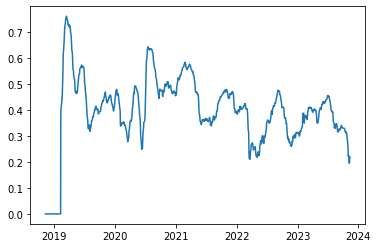

In [94]:
plt.plot(pd.to_datetime(df['date'].unique()),df.groupby('date')['p_v_corr'].mean())

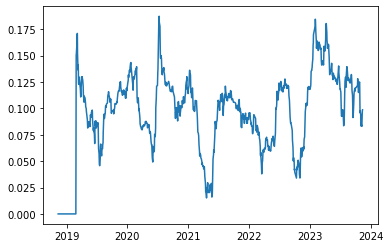

In [82]:
plt.plot(pd.to_datetime(df['date'].unique()),df.groupby('date')['r_v_corr_2'].mean())

In [95]:
df_sh300['p_v_corr'] = df_sh300[['close','daily_trade_sqrt_value']].rolling(horizen).corr()['daily_trade_sqrt_value'][::2].fillna(0).values
df_sh300['r_v_corr'] = df_sh300[['return_percent','daily_trade_sqrt_value']].rolling(horizen).corr()['daily_trade_sqrt_value'][::2].fillna(0).values

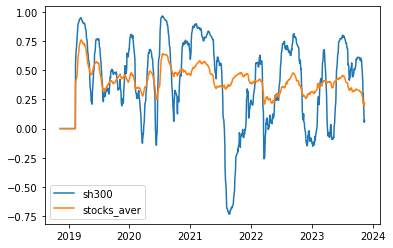

In [97]:
plt.plot(pd.to_datetime(df_sh300.index),df_sh300['p_v_corr'],label='sh300')
plt.plot(pd.to_datetime(df['date'].unique()),df.groupby('date')['p_v_corr'].mean(),label='stocks_aver')
plt.legend()

# volatility grouping

In [60]:
horizan = 60
df_sh300['vol'] = df_sh300['return_percent'].rolling(horizan).std().fillna(0)
df['vol'] = df.groupby('id')['return_percent'].rolling(horizan).std().reset_index(drop=True).fillna(0)

In [61]:
df.set_index('date',inplace=True)
df['index_vol'] = df_sh300['vol']
df.reset_index(inplace=True)

In [62]:
df['more_vol'] = (df['vol']**2-df['index_vol']**2).fillna(0)

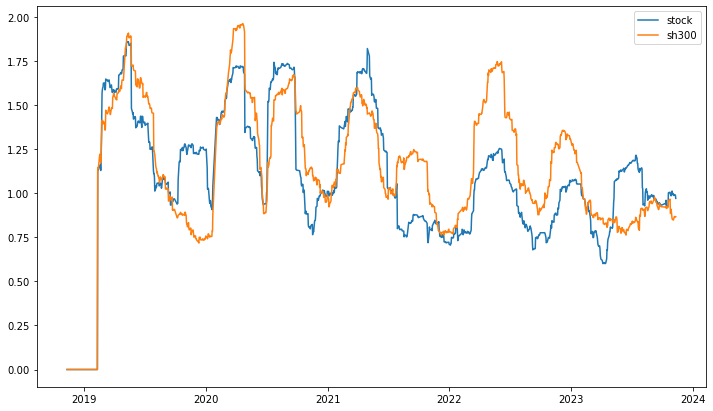

In [63]:
stock_list = df['id'].unique()
df_stock = df.groupby('id').get_group(stock_list[117])
plt.figure(figsize=(12,7))
plt.plot(pd.to_datetime(df_stock['date']),df_stock['vol'],label = 'stock')
plt.plot(pd.to_datetime(df_sh300.index),df_sh300['vol'],label='sh300')
#plt.plot(pd.to_datetime(df_stock['date']),df_stock['more_vol'],label = 'extra')
plt.legend()

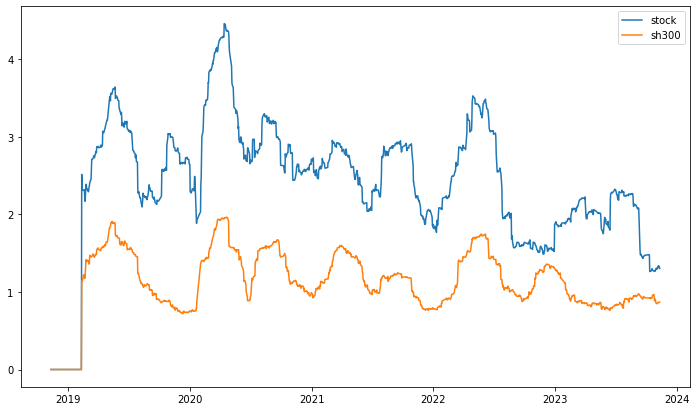

In [64]:
stock_list = df['id'].unique()
df_stock = df.groupby('id').get_group(stock_list[180])
plt.figure(figsize=(12,7))
plt.plot(pd.to_datetime(df_stock['date']),df_stock['vol'],label = 'stock')
plt.plot(pd.to_datetime(df_sh300.index),df_sh300['vol'],label='sh300')
#plt.plot(pd.to_datetime(df_stock['date']),df_stock['more_vol'],label = 'extra')
plt.legend()

In [65]:
stock_list[117]

'600000.SH'

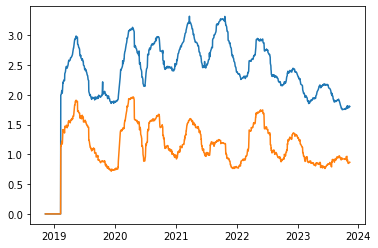

In [81]:
df['vol_2']=df['vol']**2
plt.plot(pd.to_datetime(df_stock['date']),df.groupby('date')['vol'].mean(),label = 'stock')
plt.plot(pd.to_datetime(df_sh300.index),df_sh300['vol'],label='sh300')


In [67]:
df.groupby('date')['vol_2'].sum()/df.groupby('date')['index_vol'].mean()**2

date
2018-11-12            NaN
2018-11-13            NaN
2018-11-14            NaN
2018-11-15            NaN
2018-11-16            NaN
                 ...     
2023-11-06    1446.225991
2023-11-07    1449.581679
2023-11-08    1449.457984
2023-11-09    1452.923759
2023-11-10    1440.376861
Length: 1214, dtype: float64